In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

return_series_name = "train/episode_reward"
test_return_series_name = "eval/mean_episode_reward"


# These lines are used to avoid picke errors, credit SO
# https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [159]:

def parse_np_file(file_name, series_name):
    data = np.load(file_name)
    outer_dict = data.reshape(1,)[0]
    key = list(outer_dict.keys())[0]
    dicts = outer_dict[key]
    timesteps = list(dicts.keys())
    mean_rews = [d[series_name] for d in dicts.values()]
    data = np.stack([timesteps, mean_rews], axis=1)
    all_data = pd.DataFrame(data=data, columns=["Steps","Returns"])
    return all_data
    
    
    
def plot_avg(file_names_dict, x_label, y_label, title, save_name=False, last_bold=False, scale=1, 
             load_from_tb=False, base_dir=None, avg_every=None, clip_to=None, series_name=return_series_name):
    legend = []

    for file_names in file_names_dict.keys():
        runs = []
        steps_list = []
        max_steps = 0
        # Load all the files from numpy arrays
        run_list, alternating = file_names_dict[file_names]
        for seed in run_list:
            full_file_name = os.path.join(base_dir, seed)
            out = parse_np_file(full_file_name, series_name)
            csv = pd.DataFrame(data=out['Returns'].values, columns=['Returns'])
            steps = out['Steps'].values.astype(int)
            if avg_every:
                csv = csv.ewm(span=avg_every).mean()
            
            runs.append(csv)
            steps_list.append(steps)
            
        if len(runs) > 0:
            legend.append(file_names)
            # Pad runs with nan so we only average over whatever points we have
            max_len = max([len(run) for run in runs])
            min_len = min([len(run) for run in runs])
            max_val = max([len(step) for step in steps_list])
            padded_runs = []
            for run in runs:
                pad_run = np.pad(run, (0, max_len - len(run)), 'constant', constant_values=np.nan)
                pad_run = pad_run[:,0]
                padded_runs.append(pad_run)
                
            # We're going to use the longest 'steps' array as our x-axis.  First, check that the steps match
            longest_step = sorted(steps_list, key=len)[-1]
            for step in steps_list:
                assert np.array_equal(step, longest_step[:len(step)]), ("Steps don't match", step, longest_step)
            assert len(longest_step) == max_len
                
            # Find the mean and std
            mean_arr = np.nanmean(np.stack(padded_runs), axis=0)
            std_arr = np.nanstd(np.stack(padded_runs), axis=0)
 
            # Re-index alternating runs if necessary
            if alternating:
                longest_step, (mean_arr, std_arr) = reindex_runs(longest_step, [mean_arr, std_arr])     
            
            # If necessary, clip all the runs to the same length
            if clip_to is not None:
                if longest_step[-1] >= clip_to:
                    index = np.argmax(longest_step >= clip_to)
                    longest_step = longest_step[:index]
                    mean_arr = mean_arr[:index]
                    std_arr = std_arr[:index]
            
            # Get points for the x- axis
            x = longest_step * scale   
    
            # Actually plot
            plt.plot(x, mean_arr)
            plt.fill_between(x, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)
        else:
            print("no runs for", file_names)
    
    # Add text to the graph and show it
    if legend:
        plt.legend(legend)
    plt.xlabel(x_label, fontdict = {'fontsize' : 16})
    plt.ylabel(y_label, fontdict = {'fontsize' : 16})
    plt.title(title, fontdict = {'fontsize' : 20})
    if save_name:
        plt.savefig(save_name)
    plt.show()

    

In [127]:
pretrain_steps = 100000  # TODO: Set this to collect_sp_itrs + pretrain_sp_itrs + update_sp_itrs
sp_itrs = 10000
policy_itrs = 40000

def is_training_phase(timestep):
    offset = 0
    # Loop through timesteps, alternating between phases
    if timestep == 0:
        return False, 0
    t = 0
    is_policy_phase = False
    while t < timestep:  # TODO: think through < or <=
        if t == 0:
            t += pretrain_steps
            offset += pretrain_steps
        else:
            if is_policy_phase:
                t += policy_itrs
            else:
                t += sp_itrs
                offset += sp_itrs
        is_policy_phase = not is_policy_phase
    return not is_policy_phase, timestep - offset
        

def reindex_runs(steps, arrs):
    # indices says which indices to keep (i.e. which were collected during policy phase)
    results = [is_training_phase(s) for s in steps]
    indices = np.array([r[0] for r in results])
    reindexed_steps = np.array([r[1] for r in results])
    reindexed_steps = reindexed_steps[indices]
    arrs = [a[indices] for a in arrs]
    return reindexed_steps, arrs
    

In [141]:
def plot_final_returns(plot_dict, label_x, label_y, condition, series_name, clip_to=None, scale=.001):
    for k, (run_list, alternate) in plot_dict.items():
        full_run_list = [os.path.join(run_name, "eval_scores.npy") for run_name in run_list]
        plot_dict[k] = (full_run_list, alternate)
    
    plot_avg(plot_dict, label_x, label_y, condition,
                 save_name=f"IMPROVED_{condition}.png", base_dir=base_path,
                 avg_every=25, load_from_tb=True, scale=scale, clip_to=clip_to, series_name=series_name)



def filter_by_ID(IDs):
        files = []
        for ID in IDs:
            filtered_files = list(filter(lambda x: str(ID) in x, basedir))
            if len(filtered_files) > 0:
                files.append(filtered_files[0])
        return files


# PAPER PLOTS - Return

In [6]:
test_return_series_name = "mean_ep_reward"

base_path = "/home/olivia/Sim2Real/Sim2/sim2real2sim_rad/paper_tb/tb_plots/"

## Ball in Cup

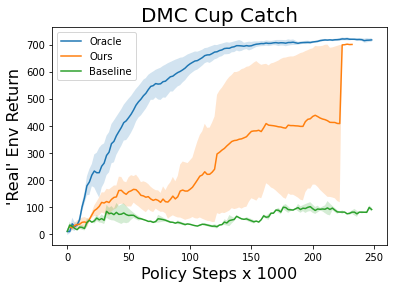

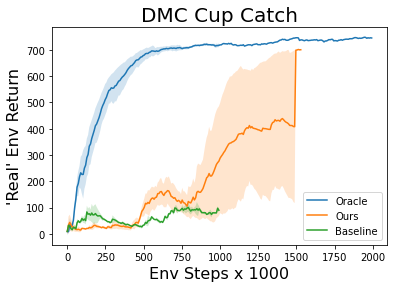

In [160]:
# DMC CUP CATCH

oracle_runs = [
    "S0602_dmc_ball_in_cup-catch-im84-b128-s2-curl_sac-pixel-crop",
    "S2018_dmc_ball_in_cup-catch-im84-b128-s3-curl_sac-pixel-crop",
    "2048_dmc_ball_in_cup-catch-im84-b128-s5-curl_sac-pixel-crop",
]
ol3_runs = [
    # BAD BAD BAD
    "S3077b_dmc_ball_in_cup-catch-im84-b128-s0-curl_sac-pixel-crop",
    "S3081_dmc_ball_in_cup-catch-im84-b128-s1-curl_sac-pixel-crop",
    
    # GOOD GOOD GOOD
#     "S3096_dmc_ball_in_cup-catch-im84-b128-s0-curl_sac-pixel-crop",
#     "S3100_dmc_ball_in_cup-catch-im84-b128-s1-curl_sac-pixel-crop",
# #    "S3104_dmc_ball_in_cup-catch-im84-b128-s1-curl_sac-pixel-crop",
]
baseline_runs = [
    "S2059_dmc_ball_in_cup-catch-im84-b128-s0-curl_sac-pixel-crop",
    "S2032_dmc_ball_in_cup-catch-im84-b128-s1-curl_sac-pixel-crop",
#     "S2034_dmc_ball_in_cup-catch-im84-b128-s2-curl_sac-pixel-crop"
]
plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

label_x = "Policy Steps x 1000"
label_y = "'Real' Env Return"
condition = "DMC Cup Catch"
plot_final_returns(plot_dict, label_x, label_y, condition, test_return_series_name, clip_to=250000)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

label_x = "Env Steps x 1000"
label_y = "'Real' Env Return"
condition = "DMC Cup Catch"
plot_final_returns(plot_dict, label_x, label_y, condition, test_return_series_name, clip_to=500000, scale=.001 * 4)


## Walker

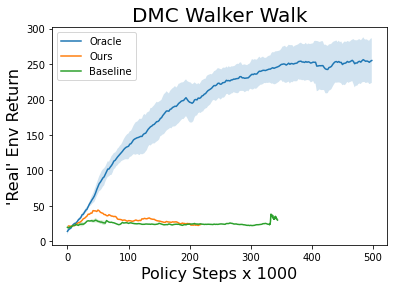

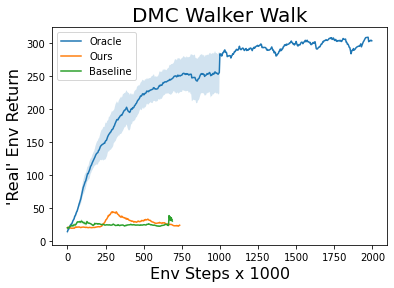

In [161]:
# DMC WALKER
oracle_runs = [
    "S0600_dmc_walker-walk-im84-b128-s2-curl_sac-pixel-crop",
    "S2014_dmc_walker-walk-im84-b128-s3-curl_sac-pixel-crop",
    "2049_dmc_walker-walk-im84-b128-s5-curl_sac-pixel-crop",
]
ol3_runs = [
    # BAD BAD BAD
    "S3078b_dmc_walker-walk-im84-b128-s0-curl_sac-pixel-crop",
    "S3082_dmc_walker-walk-im84-b128-s1-curl_sac-pixel-crop",
    # GOOD
#     "S3097_dmc_walker-walk-im84-b128-s0-curl_sac-pixel-crop",
#     "S3101_dmc_walker-walk-im84-b128-s1-curl_sac-pixel-crop",
# #     "S3105_dmc_walker-walk-im84-b128-s1-curl_sac-pixel-crop",
]
baseline_runs = [
    "S2060_dmc_walker-walk-im84-b128-s0-curl_sac-pixel-crop",
    "S2033_dmc_walker-walk-im84-b128-s1-curl_sac-pixel-crop",
#     "S2037_dmc_walker-walk-im84-b128-s2-curl_sac-pixel-crop",
]
plot_dict = {
    "Oracle": oracle_runs,
    "Ours": ol3_runs,
    "Baseline": baseline_runs,
}

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

label_x = "Policy Steps x 1000"
label_y = "'Real' Env Return"
condition = "DMC Walker Walk"
plot_final_returns(plot_dict, label_x, label_y, condition, test_return_series_name, clip_to=500000)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

label_x = "Env Steps x 1000"
label_y = "'Real' Env Return"
condition = "DMC Walker Walk"
plot_final_returns(plot_dict, label_x, label_y, condition, test_return_series_name, clip_to=1000000, scale=.001 * 2)


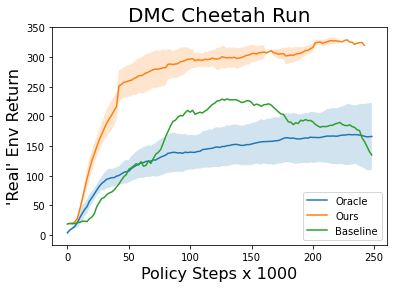

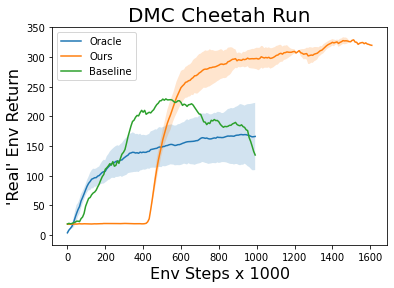

In [162]:
# DMC CHEETAH

oracle_runs = [
    "S2019_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
    "S2020_dmc_cheetah-run-im84-b128-s2-curl_sac-pixel-crop",
    "2050_dmc_cheetah-run-im84-b128-s5-curl_sac-pixel-crop",
]

ol3_runs = [
    "S3079b_dmc_cheetah-run-im84-b128-s0-curl_sac-pixel-crop",
    "S3083_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
#     "S3098_dmc_cheetah-run-im84-b128-s0-curl_sac-pixel-crop",
#     "S3102_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
# #     "S3106_dmc_cheetah-run-im84-b128-s2-curl_sac-pixel-crop",
]
baseline_runs = [
    "S2061_dmc_cheetah-run-im84-b128-s0-curl_sac-pixel-crop",
    "S2034_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
#     "S2038_dmc_cheetah-run-im84-b128-s2-curl_sac-pixel-crop"
]
plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

label_x = "Policy Steps x 1000"
label_y = "'Real' Env Return"
condition = "DMC Cheetah Run"
plot_final_returns(plot_dict, label_x, label_y, condition, test_return_series_name, clip_to=250000)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

label_x = "Env Steps x 1000"
label_y = "'Real' Env Return"
condition = "DMC Cheetah Run"
plot_final_returns(plot_dict, label_x, label_y, condition, test_return_series_name, clip_to=1000000, scale=.001 * 4)


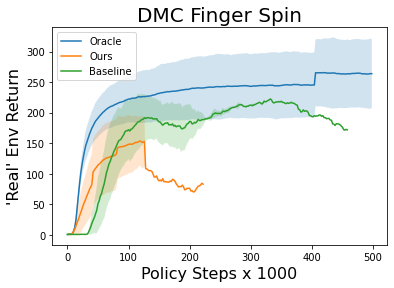

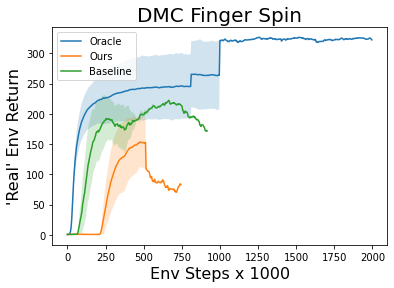

In [164]:
# DMC FINGER
oracle_runs = [
    "S0603_dmc_finger-spin-im84-b128-s2-curl_sac-pixel-crop",
    "S2016_dmc_finger-spin-im84-b128-s3-curl_sac-pixel-crop",
    "2051_dmc_finger-spin-im84-b128-s5-curl_sac-pixel-crop",
]
ol3_runs = [
    "S3080b_dmc_finger-spin-im84-b128-s0-curl_sac-pixel-crop",
    "S3084_dmc_finger-spin-im84-b128-s1-curl_sac-pixel-crop"
#     "S3099_dmc_finger-spin-im84-b128-s0-curl_sac-pixel-crop",
#     "S3103_dmc_finger-spin-im84-b128-s1-curl_sac-pixel-crop",
# #     "S3107_dmc_finger-spin-im84-b128-s2-curl_sac-pixel-crop"
]
baseline_runs = [
    "S2062_dmc_finger-spin-im84-b128-s0-curl_sac-pixel-crop",
    "S2035_dmc_finger-spin-im84-b128-s1-curl_sac-pixel-crop",
#     "S2039_dmc_finger-spin-im84-b128-s2-curl_sac-pixel-crop",
]

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

label_x = "Policy Steps x 1000"
label_y = "'Real' Env Return"
condition = "DMC Finger Spin"
plot_final_returns(plot_dict, label_x, label_y, condition, test_return_series_name, clip_to=500000)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

label_x = "Env Steps x 1000"
label_y = "'Real' Env Return"
condition = "DMC Finger Spin"
plot_final_returns(plot_dict, label_x, label_y, condition, test_return_series_name, clip_to=1000000, scale=.001 * 2)


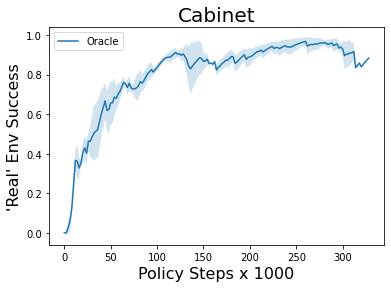

In [169]:
test_return_series_name = "mean_ep_success"

# DMC FINGER
oracle_runs = [
    "S0938_kitchen-real_c-im84-b128-s0-curl_sac-pixel-crop",
    "S0939_kitchen-real_c-im84-b128-s1-curl_sac-pixel-crop",
    "S0940_kitchen-real_c-im84-b128-s2-curl_sac-pixel-crop",
]


plot_dict = {
    "Oracle": (oracle_runs, False),
}

label_x = "Policy Steps x 1000"
label_y = "'Real' Env Success"
condition = "Cabinet"
plot_final_returns(plot_dict, label_x, label_y, condition, test_return_series_name, clip_to=500000)
